
# Model Selection by Backtesting


## Initialization

In [45]:

import os, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE = Path('../data/backtest')
PROCESSED = Path('../data/processed')
RAW = Path('../data/raw')  
BASE.mkdir(parents=True, exist_ok=True)

plt.rcParams['figure.figsize'] = (9, 5)

def equity_curve(returns: pd.Series) -> pd.Series:
    return (1.0 + returns.fillna(0.0)).cumprod()

def max_drawdown(curve: pd.Series) -> float:
    peak = curve.cummax()
    dd = (curve / peak) - 1.0
    return float(dd.min())

def annualized_stats(monthly_rets: pd.Series):
    r = monthly_rets.dropna()
    if r.empty:
        return np.nan, np.nan, np.nan
    n = len(r)
    cagr = (1.0 + r).prod() ** (12.0 / n) - 1.0
    vol_ann = r.std(ddof=1) * np.sqrt(12.0)
    sharpe = (r.mean() * 12.0) / vol_ann if vol_ann > 0 else np.nan
    return float(cagr), float(vol_ann), float(sharpe)


## Features and Target

In [51]:
# List all features
x_features = PROCESSED / 'x_features.csv'
x_df = pd.read_csv(x_features, parse_dates=['date'])
x_cols = [col for col in x_df.columns if col != 'date']
print(f'Features ({len(x_cols)}): {x_cols}')
# Target
y_target = PROCESSED / 'y_targets.csv'
y_df = pd.read_csv(y_target, parse_dates=['date'])
print(f'Target: next-month relative return vs. SPY values from {y_df["date"].min().date()} to {y_df["date"].max().date()}')

Features (102): ['XLF_r1m', 'XLK_r1m', 'XLE_r1m', 'XLV_r1m', 'XLI_r1m', 'XLP_r1m', 'XLY_r1m', 'XLB_r1m', 'XLU_r1m', 'SPY_r1m', 'XLF_r3m', 'XLK_r3m', 'XLE_r3m', 'XLV_r3m', 'XLI_r3m', 'XLP_r3m', 'XLY_r3m', 'XLB_r3m', 'XLU_r3m', 'SPY_r3m', 'XLF_r6m', 'XLK_r6m', 'XLE_r6m', 'XLV_r6m', 'XLI_r6m', 'XLP_r6m', 'XLY_r6m', 'XLB_r6m', 'XLU_r6m', 'SPY_r6m', 'XLF_r12m', 'XLK_r12m', 'XLE_r12m', 'XLV_r12m', 'XLI_r12m', 'XLP_r12m', 'XLY_r12m', 'XLB_r12m', 'XLU_r12m', 'SPY_r12m', 'XLF_vol3', 'XLK_vol3', 'XLE_vol3', 'XLV_vol3', 'XLI_vol3', 'XLP_vol3', 'XLY_vol3', 'XLB_vol3', 'XLU_vol3', 'SPY_vol3', 'XLF_vol6', 'XLK_vol6', 'XLE_vol6', 'XLV_vol6', 'XLI_vol6', 'XLP_vol6', 'XLY_vol6', 'XLB_vol6', 'XLU_vol6', 'SPY_vol6', 'XLF_RSI14', 'XLK_RSI14', 'XLE_RSI14', 'XLV_RSI14', 'XLI_RSI14', 'XLP_RSI14', 'XLY_RSI14', 'XLB_RSI14', 'XLU_RSI14', 'SPY_RSI14', 'XLF_MACD', 'XLK_MACD', 'XLE_MACD', 'XLV_MACD', 'XLI_MACD', 'XLP_MACD', 'XLY_MACD', 'XLB_MACD', 'XLU_MACD', 'SPY_MACD', 'XLF_MACDsig', 'XLK_MACDsig', 'XLE_MACDsig'

## Load all metrics and build a leaderboard

In [41]:

# Load all metrics_*.csv
rows = []
metric_paths = sorted(BASE.glob('metrics_*.csv'))
if not metric_paths:
    raise FileNotFoundError("No metrics_*.csv found in data/backtest/. Run src/backtest.py for your models first.")

for p in metric_paths:
    df = pd.read_csv(p)
    cfg = p.stem.replace('metrics_','')
    df['config'] = cfg
    rows.append(df)

leader = pd.concat(rows, ignore_index=True)

# Fill any missing columns that some runs may not have
for col in ['CAGR','Vol_ann','Sharpe','MaxDD','Hit_ratio','Turnover_avg','n_months']:
    if col not in leader.columns:
        leader[col] = np.nan

# Sort by highest Sharpe, then highest CAGR, then *smallest* MaxDD
leader = leader.sort_values(['Sharpe','CAGR','MaxDD'], ascending=[False, False, True]).reset_index(drop=True)
leader.to_csv(BASE / 'leaderboard.csv', index=False)
leader.head(10)

,n_months,CAGR,Vol_ann,Sharpe,MaxDD,Hit_ratio,Turnover_avg,top_k,long_short,config
0,232,-0.009611,0.068297,-0.107216,-0.373446,0.469828,0.561063,3,False,classification_xgb_top3
1,232,-0.010399,0.062707,-0.135340,-0.419797,0.508621,0.457615,3,False,classification_logit_top3
2,232,-0.017956,0.069663,-0.224779,-0.452691,0.504310,0.492098,3,False,classification_rf_top3
3,232,-0.025861,0.068017,-0.350706,-0.536935,0.478448,0.486351,3,False,regression_ridge_top3
4,232,-0.036363,0.069742,-0.495182,-0.539151,0.461207,0.592672,3,False,regression_xgb_top3
5,232,-0.050586,0.070707,-0.696898,-0.663756,0.426724,0.500718,3,False,regression_rf_top3


## Visualize aggregate comparisons

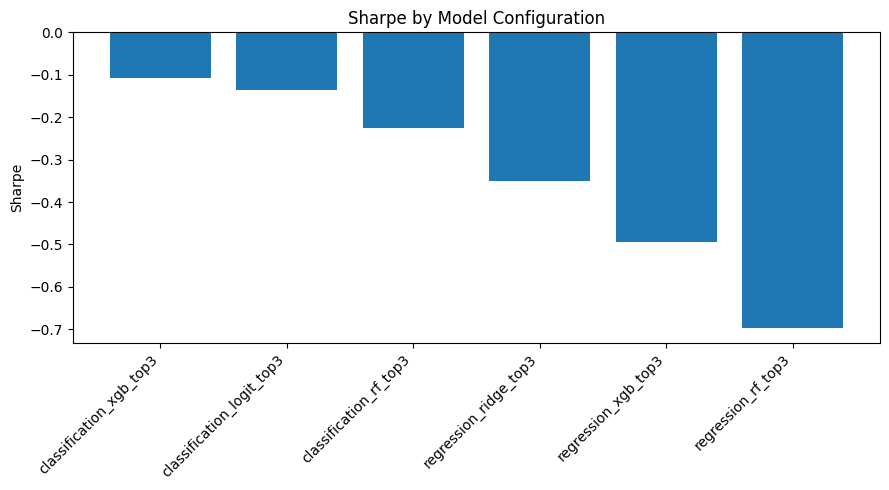

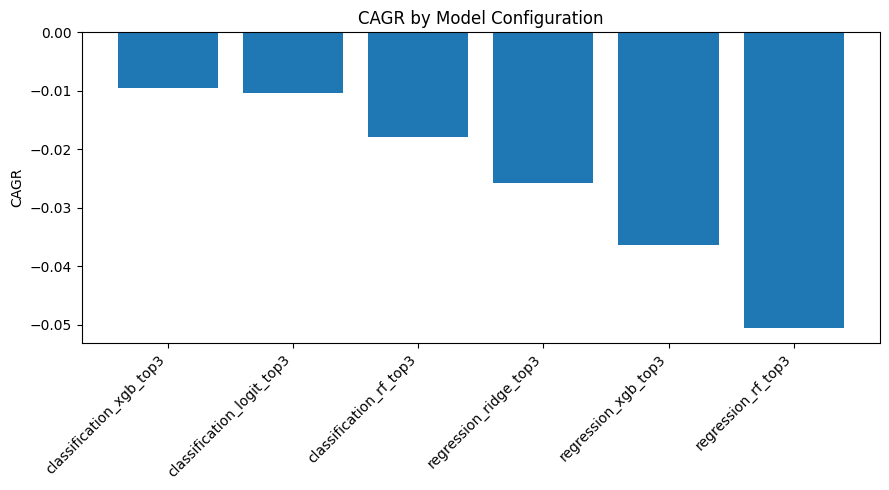

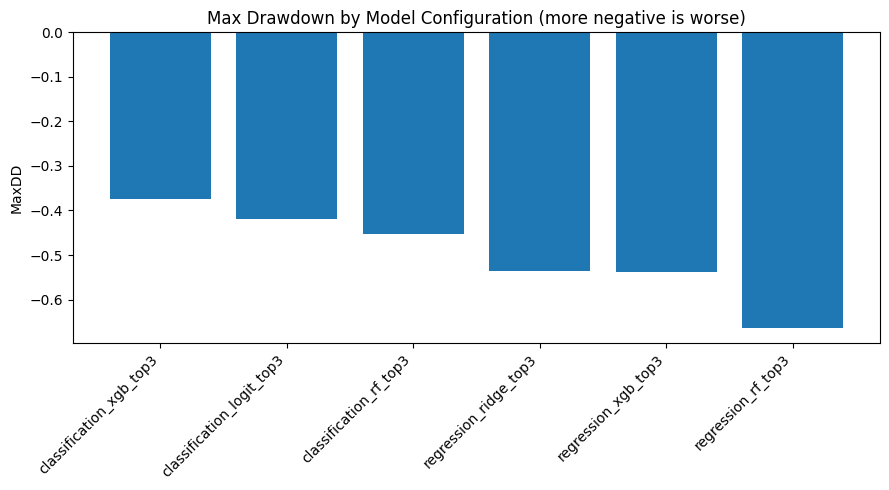

In [42]:

# Bar charts for Sharpe, CAGR, MaxDD across all configs
fig = plt.figure()
x = np.arange(len(leader))
plt.bar(x, leader['Sharpe'].values)
plt.xticks(x, leader['config'].values, rotation=45, ha='right')
plt.title('Sharpe by Model Configuration')
plt.ylabel('Sharpe')
plt.tight_layout()
plt.show()

fig = plt.figure()
plt.bar(x, leader['CAGR'].values)
plt.xticks(x, leader['config'].values, rotation=45, ha='right')
plt.title('CAGR by Model Configuration')
plt.ylabel('CAGR')
plt.tight_layout()
plt.show()

fig = plt.figure()
plt.bar(x, leader['MaxDD'].values)
plt.xticks(x, leader['config'].values, rotation=45, ha='right')
plt.title('Max Drawdown by Model Configuration (more negative is worse)')
plt.ylabel('MaxDD')
plt.tight_layout()
plt.show()


## Equity curves for all models

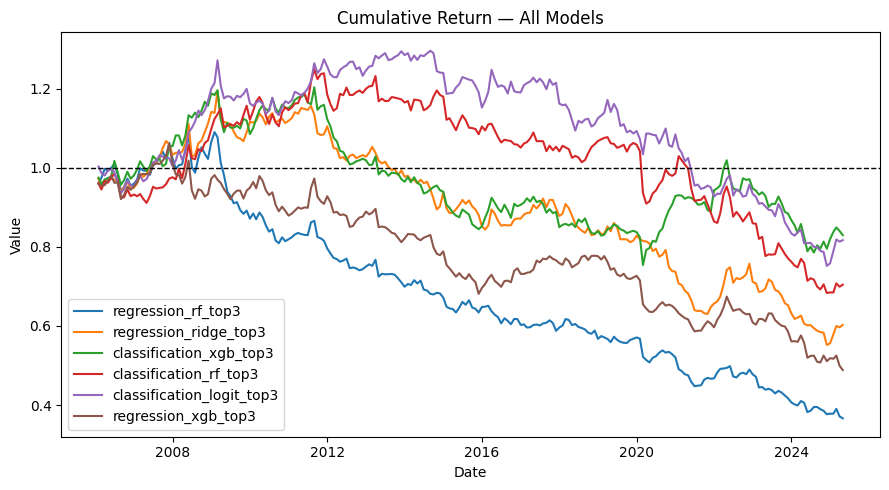

In [43]:

# Load all portfolio_*.csv and build curves
curves = []
for p in BASE.glob('portfolio_*.csv'):
    cfg = p.stem.replace('portfolio_','')
    df = pd.read_csv(p, parse_dates=['date']).sort_values('date')
    col = 'port_ret'
    ret = df[col]
    cur = equity_curve(ret)
    curves.append(pd.DataFrame({'date': df['date'], cfg: cur.values}))

# Merge on date
from functools import reduce
curves_merged = reduce(lambda L, R: pd.merge(L, R, on='date', how='outer'), curves).sort_values('date')
curves_merged['date'] = pd.to_datetime(curves_merged['date']).dt.to_period('M').dt.to_timestamp('M')
curves_merged = curves_merged.dropna(how='all', axis=1)
curves_merged.to_csv(BASE / 'all_model_curves.csv', index=False)

# Plot all curves
fig = plt.figure()
for c in curves_merged.columns:
    if c == 'date':
        continue
    plt.plot(curves_merged['date'], curves_merged[c], label=c)
# horizontal line at 1
plt.axhline(1.0, color='k', linestyle='--', linewidth=1, label='_nolegend_')
plt.title('Cumulative Return — All Models')
plt.xlabel('Date'); plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


## Pick the best model

In [37]:

best_config = leader.loc[0, 'config']
best_config

'classification_xgb_top3'

## Best model equity curve, rolling Sharpe, drawdown

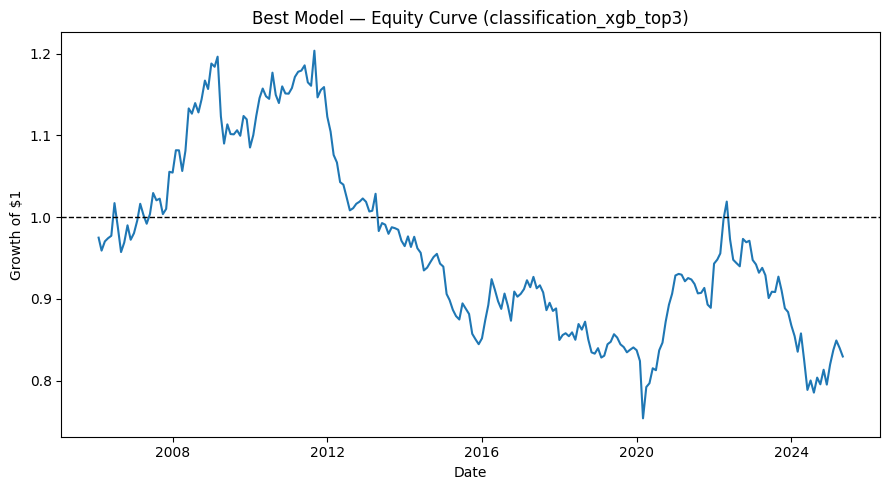

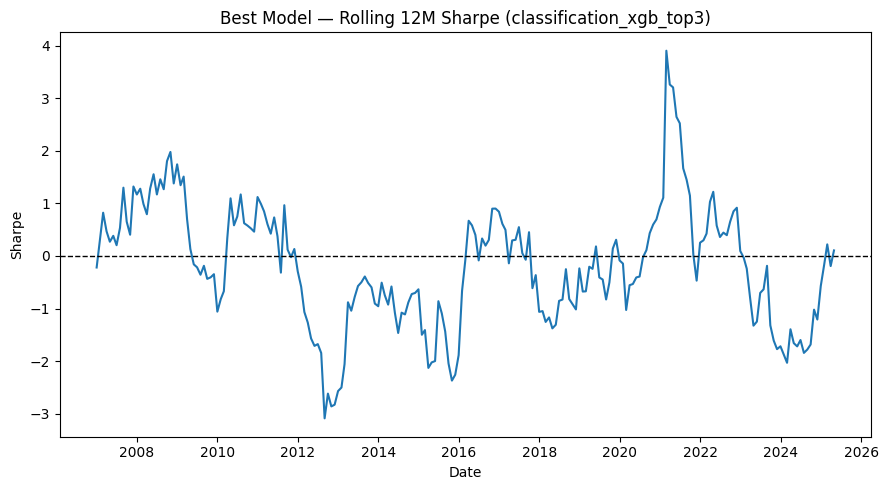

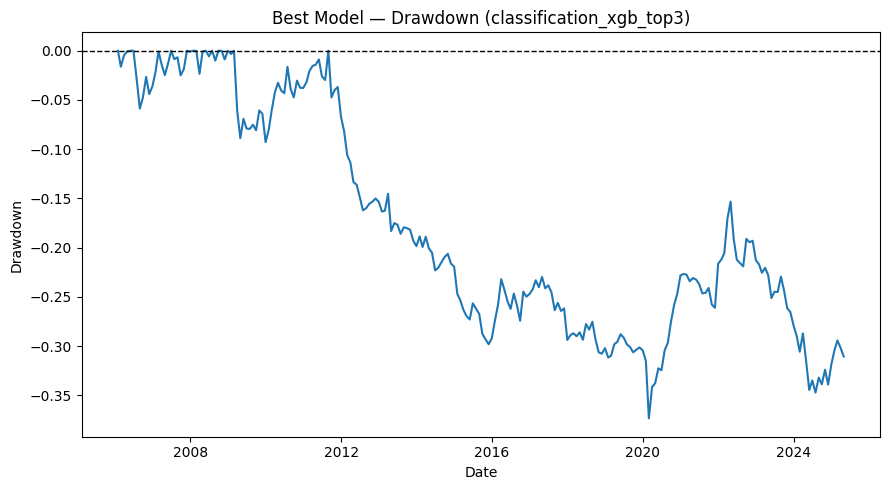

In [38]:

# Load best portfolio
best_port_path = BASE / f'portfolio_{best_config}.csv'
best_df = pd.read_csv(best_port_path, parse_dates=['date']).sort_values('date')
best_df['date'] = best_df['date'].dt.to_period('M').dt.to_timestamp('M')
best_ret = best_df['port_ret']
best_curve = equity_curve(best_ret)

# Rolling 12M Sharpe
roll_sharpe = best_ret.rolling(12).apply(lambda x: (x.mean()*12.0)/(x.std(ddof=1)*np.sqrt(12.0)) if x.std(ddof=1)>0 else np.nan, raw=False)

# Drawdown
dd = (best_curve / best_curve.cummax()) - 1.0

# Plots
fig = plt.figure()
plt.plot(best_df['date'], best_curve.values)
plt.axhline(1.0, color='k', linestyle='--', linewidth=1, label='_nolegend_')
plt.title(f'Best Model — Equity Curve ({best_config})')
plt.xlabel('Date'); plt.ylabel('Growth of $1')
plt.tight_layout(); plt.show()

fig = plt.figure()
plt.plot(best_df['date'], roll_sharpe.values)
plt.axhline(0.0, color='k', linestyle='--', linewidth=1, label='_nolegend_')
plt.title(f'Best Model — Rolling 12M Sharpe ({best_config})')
plt.xlabel('Date'); plt.ylabel('Sharpe')
plt.tight_layout(); plt.show()

fig = plt.figure()
plt.plot(best_df['date'], dd.values)
plt.axhline(0.0, color='k', linestyle='--', linewidth=1, label='_nolegend_')
plt.title(f'Best Model — Drawdown ({best_config})')
plt.xlabel('Date'); plt.ylabel('Drawdown')
plt.tight_layout(); plt.show()

# Export best-model artifacts
best_curve_df = pd.DataFrame({'date': best_df['date'], 'curve': best_curve.values})
best_curve_df.to_csv(BASE / f'curve_{best_config}.csv', index=False)
pd.DataFrame({'date': best_df['date'], 'rolling_sharpe_12m': roll_sharpe.values}).to_csv(BASE / f'rolling_sharpe_{best_config}.csv', index=False)
pd.DataFrame({'date': best_df['date'], 'drawdown': dd.values}).to_csv(BASE / f'drawdown_{best_config}.csv', index=False)


## Compare to SPY

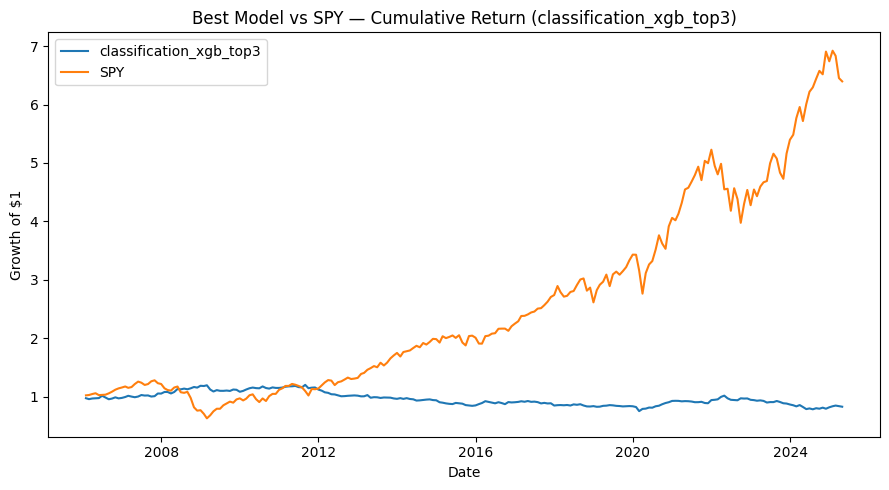

In [39]:

spy_path = RAW / 'etf_data.csv'
if spy_path.exists():
    prices = pd.read_csv(spy_path, parse_dates=['date'])
    prices['date'] = pd.to_datetime(prices['date'])

    # Monthly close → monthly returns
    spy = (prices.set_index('date')['SPY']
                .resample('ME').last()
                .pct_change()
                .dropna())

    # Align to best model date
    spy = spy.reindex(best_df['date']).fillna(0.0)
    spy_curve = equity_curve(spy)

    fig = plt.figure()
    plt.plot(best_df['date'], best_curve.values, label=best_config)
    plt.plot(best_df['date'], spy_curve.values, label='SPY')
    plt.title(f'Best Model vs SPY — Cumulative Return ({best_config})')
    plt.xlabel('Date'); plt.ylabel('Growth of $1')
    plt.legend(); plt.tight_layout(); plt.show()

    pd.DataFrame({'date': best_df['date'], 'portfolio': best_curve.values, 'SPY': spy_curve.values}).to_csv(
        BASE / f'best_vs_spy_{best_config}.csv', index=False
    )
else:
    print("SPY not found at data/raw/etf_data.csv — skipping benchmark plot.")
